#### Setup

In [98]:
import os
import pathlib
import pandas as pd
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from shapely.affinity import *
from shapely.geometry import Polygon, Point

In [58]:
# convert geometry to list of points
def to_coords(geometry):
    return [float(i) for i in geometry.to_wkt().replace('(', '').replace(')', '').replace(',', '').split()[1:]]

In [65]:
# given a shapely polygon, return a matplotlib PathPatch
def patch(polygon):
    
    # load the bounding box from the dataframe
    bbox = to_coords(polygon)
    
    # convert to array of vertices
    try:
        vertices = [(bbox[x], bbox[x+1]) for x in range(0,8,2)]
        vertices += [(0, 0)]
    except:
        vertices = [(0, 0)] * 5

    # create a patch based on the verticies
    codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
    vertices = np.array(vertices, float)
    path = Path(vertices, codes)
    return PathPatch(path, facecolor='red', edgecolor='red', linewidth=3, fill=False)

In [3]:
# render images with a single bounding box and optional center point
def show_box(fname, polygon, center=None):
    fig, axs = plt.subplots(1, 1, figsize=(9, 9))
    axs = [[axs]]

    for row_axs in axs:
        for ax in row_axs:
            img = mpimg.imread(img_dir/fname)
            pathpatch = patch(polygon)
            if center:
                ax.scatter(*tuple(center), c='red', s=30)    # little dot
            ax.imshow(img)
            ax.set_title(fname)
            ax.axis('on')
            ax.add_patch(pathpatch)

    plt.show()

In [4]:
# setup paths
path = pathlib.Path.home()/'.fastai/data'

img_dir = path/'Data_Training'

labels_dir = path/'labels'
gt_path = labels_dir/'training_superclean_labels.json'

In [5]:
# load ground truths into dataframe
df = pd.read_json(gt_path)

#### Render polygon as bounding box

In [70]:
# pick a sample image
fname = 'IMG_0117.JPG'

In [72]:
# get the coords
x1, y1, x2, y2, x3, y3, x4, y4 = df[fname][0]

In [73]:
# create a shapely polygon
polygon = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4)])

In [74]:
polygon.area

29240.378358794937

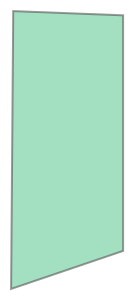

In [75]:
polygon

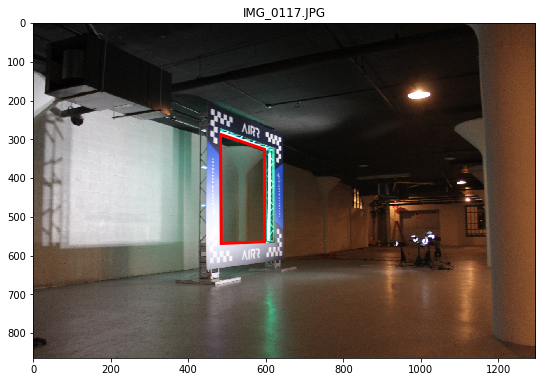

In [76]:
show_box(fname, polygon)

#### Calculate center of polygon

In [79]:
x, y = to_coords(polygon.centroid)

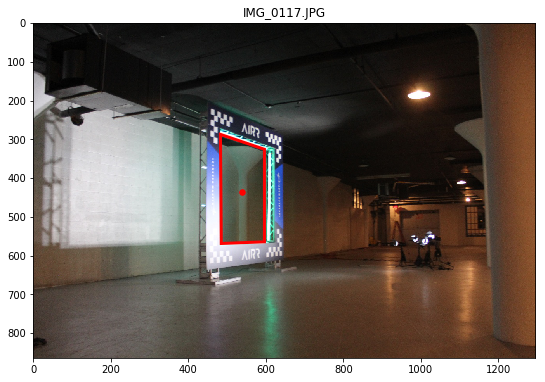

In [80]:
show_box(fname, polygon, (x,y))

#### Start with predefined square at center

In [81]:
sz = 100       # size
hsz = sz / 2   # half size
square = Polygon([(x-hsz, y-hsz), (x+hsz, y-hsz), (x+hsz, y+hsz), (x-hsz, y+hsz)])

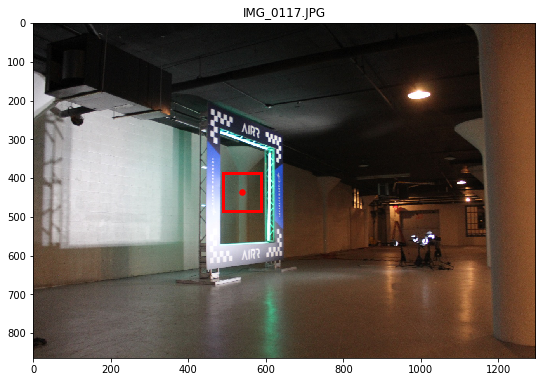

In [82]:
show_box(fname, square, (x,y))

#### Do scale transform

In [83]:
fct = 2.5    # scale factor
square = scale(square, xfact=fct, yfact=fct)

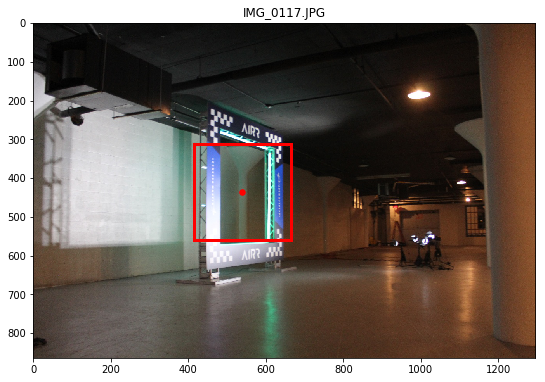

In [84]:
show_box(fname, square, (x,y))

#### Do rotation transform

In [85]:
deg = 5    # degrees
square = rotate(square, deg)

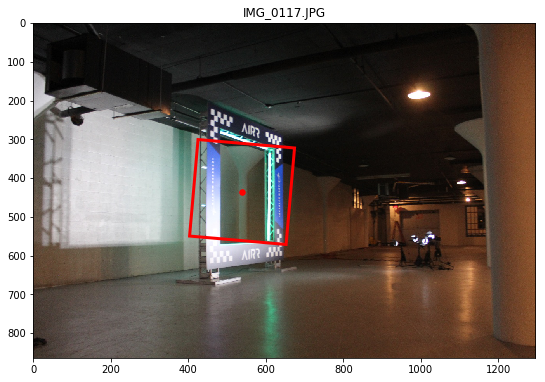

In [86]:
show_box(fname, square, (x,y))

#### Do perspective transform

In [95]:
img = PIL.Image.open(img_dir/fname)
width, height = img.size

In [99]:
#img

In [100]:
#img.transform((width, height), PIL.Image.PERSPECTIVE)

In [103]:
img = cv2.imread(str(img_dir/fname))
rows,cols,ch = img.shape

In [104]:
x1, y1

(483.0545454545, 286.9293680297)

In [111]:
pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
pts2 = np.float32([[0,0],[300,0],[300,300],[0,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)

In [112]:
M

array([[ 1.35675281e+00, -1.03217868e-02, -6.52423974e+02],
       [-2.14957483e-01,  6.33192457e-01, -7.78453335e+01],
       [-7.98992640e-04, -3.44059567e-05,  1.00000000e+00]])

In [113]:
dst = cv2.warpPerspective(img,M,(300,300))

In [114]:
#dst

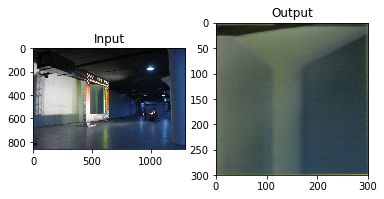

In [115]:
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()